In [2]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None

## Functions

In [3]:
def normalize_col(column):
    return (column - column.min()) / (column.max()-column.min())

In [4]:
def df_basing(df:pd.DataFrame)->(pd.DataFrame,pd.DataFrame):
    base_df = df[test_tickers[0]].fillna(method='ffill')
    diff_df = df[test_tickers[1:]]
    for col in diff_df.columns:
        diff_df.loc[:,col] = diff_df.loc[:,col].div(base_df, axis=0)
    diff_df=diff_df.apply(lambda x: x-1)
    return base_df, diff_df

In [5]:
def base_plot(tickers:list, diff_df):
    fig, ax = plt.subplots(1,1,figsize = (20,10))
    ax.axhline(0 ,color="r", label = tickers[0])
    ax.plot(diff_df,label=diff_df.columns)
    ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
    ax.set_xlabel("Date")
    ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
    ax.legend()

In [6]:
def extract_trading_days(df):
    filled_df = df.fillna(method='ffill')
    return [group[1].between_time("14:30","16:30") for group in filled_df.groupby(filled_df.index.day)]

In [22]:
def get_price_data(dates, tickers:list):
    dates = dates.values.flatten().tolist()
    start, end = datetime.utcfromtimestamp(dates[0]/1e9),datetime.utcfromtimestamp(dates[1]/1e9)
    
    data = [yf.Ticker(ticker).history(interval='5m', start=start, end=end)["Close"] for ticker in tickers]
    eur_usd = yf.Ticker('EUR=X').history(interval='5m', start=start, end=end)["Close"]
    
    price_df = pd.concat(data, axis=1, ignore_index=False) #price data
    price_df.columns = test_tickers
    eur_usd=eur_usd.reindex(price_df.index).fillna(method='ffill')
    price_df.loc[:,test_tickers[1:]] = price_df.loc[:,test_tickers[1:]].multiply(eur_usd.loc[price_df.index], axis=0)

    return_df = pd.concat(data, axis=1, ignore_index=False) #price data
    return_df.columns = test_tickers
    for col in return_df.columns:
        return_df[col] = normalize_col(return_df[col])
    
    return price_df, return_df

In [25]:
def trade(trader, time_blocks, tickers:list)->list:
    total_history = []
    for i in tqdm(range(len(time_blocks))):
        t1,t2 = get_price_data(time_blocks.loc[i], tickers) # price df, return df
        trading_days_returns = extract_trading_days(t2)
        trading_days_price = extract_trading_days(t1)
        
        bal_history = []
        for td_return, td_price in zip(trading_days_returns,trading_days_price):
            base_df, diff_df = df_basing(td_return)
            for idx in diff_df.index:
                time_stamp = idx.time()
                price_data = td_price.loc[idx].values.flatten().tolist()
                return_data = diff_df.loc[idx].values.flatten().tolist()
                trader.data_feed(time_stamp, return_data, price_data, test_tickers[1:])

                bal_history.append(trader.balance)
        total_history.append(bal_history)
    return sum(total_history,[])

## Get Price Data

In [9]:
starts = pd.bdate_range('2022-12-01', '2023-01-18', freq="7B").to_frame(index=False)
stops = pd.bdate_range('2022-12-08', '2023-01-25', freq="7B").to_frame(index=False)
time_blocks = pd.concat([starts,stops], axis = 1)

display(time_blocks)

,0,0
0,2022-12-01,2022-12-08
1,2022-12-12,2022-12-19
2,2022-12-21,2022-12-28
3,2022-12-30,2023-01-06
4,2023-01-10,2023-01-17


In [10]:
test_tickers = ["RYAAY","RYA.IR","RY4C.DE"]

In [11]:
t1,t2 = get_price_data(time_blocks.loc[0], test_tickers)

## Visual Analysis

<AxesSubplot:xlabel='Datetime'>

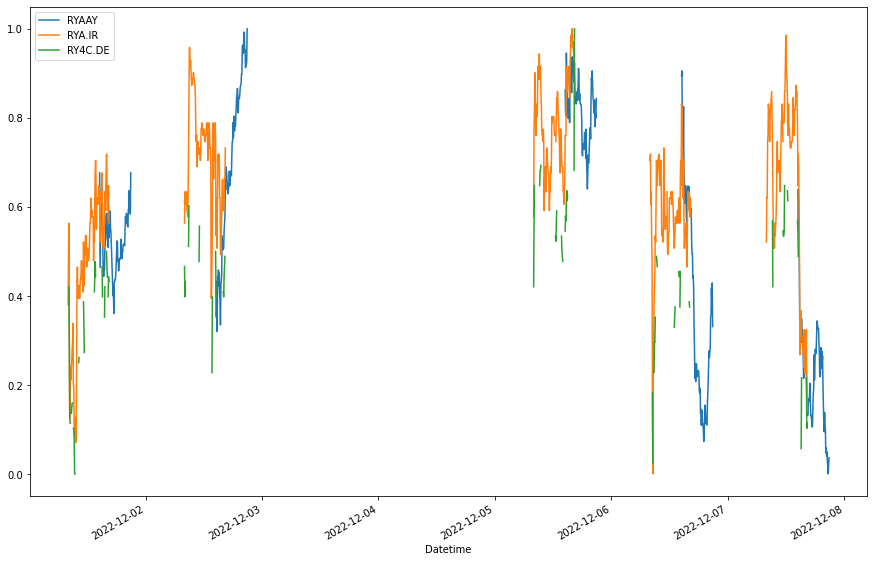

In [12]:
t2.plot(figsize=(15,10))

In [13]:
base_df, diff_df = df_basing(t2)

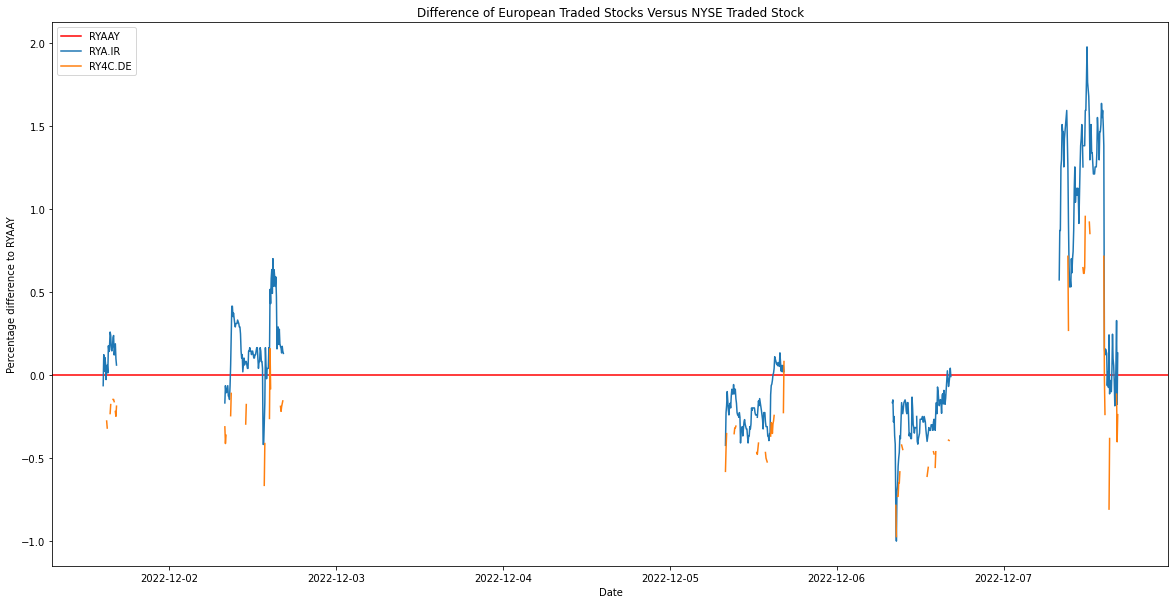

In [14]:
base_plot(test_tickers, diff_df)

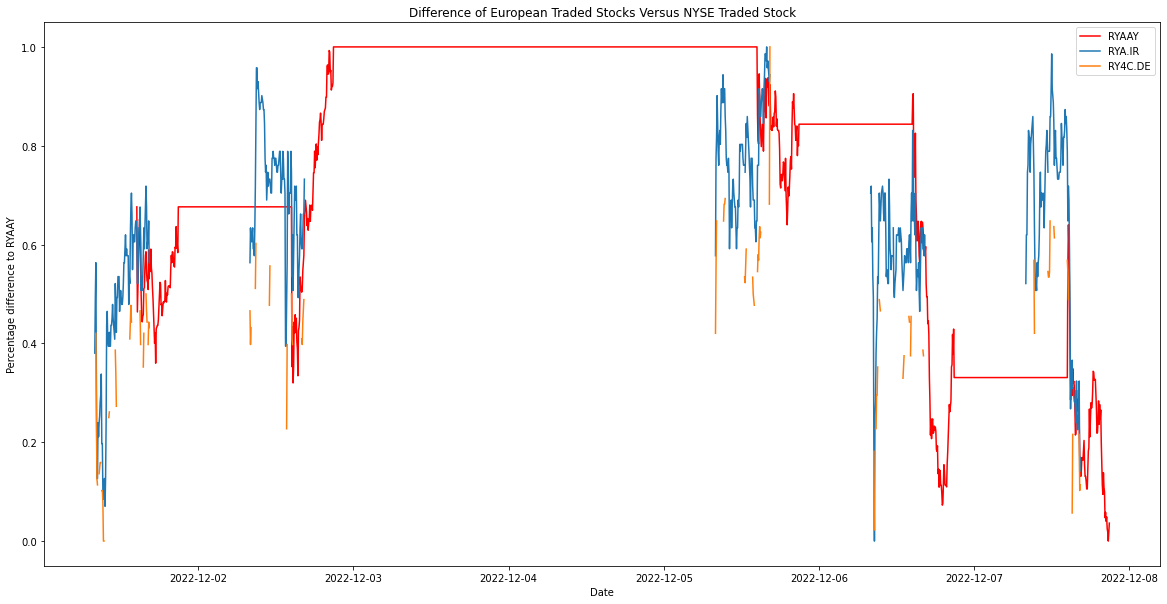

In [15]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
ax.plot(base_df, label=base_df.name , color = "r")
ax.plot(t2[test_tickers[-2:]],label=t2[test_tickers[-2:]].columns)
ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
ax.set_xlabel("Date")
ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
ax.legend()

## Trading Test

In [16]:
from IntradayRegionArbitrage import IntradayRegionArbitrage as IRA

In [17]:
trader = IRA(1000, 0.8, 0.2, 0.1, 0.05, True)

In [26]:
bal_history = trade(trader, time_blocks, test_tickers)

  0%|          | 0/5 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare-> amt: -0.6688771595060395 @76.0199966430664 --> total: -50.84803942027292
		Ticker RYA.IR-> amt: 4.253830952909122 @11.953469703702922 --> total: 50.84803942027292
		BaseShare-> amt: -0.6688771595060395 @76.0199966430664 --> total: -50.84803942027292
		Ticker RY4C.DE-> amt: 4.253830952909122 @11.953469703702922 --> total: 50.84803942027292
	take profit
	--Closing Trade
		BaseShare-> amt: 0.6688771595060395 @76.79000091552734 --> total: 51.36307769084411
		Ticker RYA.IR-> amt: -4.253830952909122 @12.00469401176548 --> total: -51.06593896745078
		PNL: 0.0292%
	take profit
	--Closing Trade
		BaseShare-> amt: 0.6688771595060395 @76.68499755859375 --> total: 51.29284334371977
		Ticker RY4C.DE-> amt: -4.253830952909122 @11.985922477152826 --> total: -50.986088032481874
		PNL: 0.0302%
	--Opening Trade
		BaseShare-> amt: -1.330845794695719 @76.45999908447266 --> total: -101.75646824400897
		Ticker RY4C.DE-> amt: 8.341950459924833 @12.198162615907677 --> total: 101

In [1]:
plt.plot(bal_history)

NameError: name 'plt' is not defined